In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import ICRS

In [4]:
figsize(10, 8)

In [5]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [6]:
rc = 335.7133441444117
dc = 63.43802542905474

In [7]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [63]:
def get_map_gal(bank='A', session='5', doplot=True, pixbeam=1.):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/datamaps_'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    c = coordinates.SkyCoord(frame='icrs', ra=ras*u.degree, dec=decs*u.degree)
    lats = c.galactic.b.deg
    lons = c.galactic.l.deg
    lonc = 107.2
    latc = 5.2
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units !!
    # units now are Jy * beam area per pixel area
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    nlonpix = int((lons.max() - lons.min()) / (pixbeam / 60.))
    nlatpix = int((lats.max() - lats.min()) / (pixbeam / 60.))    
    
    datamap, hits, lonbins, latbins = naive_map(calibrated, lons, lats, nlonpix, nlatpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    radius = np.sqrt( (lons-lonc)**2 + (lats-latc)**2)
    
    rmask = radius <= 1.
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, lonbins, latbins = naive_map(insidedata, lons, lats, nlonpix, nlatpix) 
    innerregion = innermap > 0
    
    annulus = (radius >= 80./60.) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, lonbins, latbins = naive_map(outerdata, lons, lats, nlonpix, nlatpix)
    outerregion = outermap > 0
          
    signal -= np.nanmedian(signal[outerregion])
    signal[mask] = np.nan
    
    if doplot:
        figure()
        figsize(10 ,8)
        pc = pcolormesh(lonbins, latbins, signal)
        clim(-0.11*units, 0.11*units)
        cb = colorbar()
        xlabel('LON [degrees]')
        ylabel('LAT [degrees]')
        cb.set_label('Flux [Jy/pixel]')
        title('Bank '+bank)
        savefig('figures/map'+bank+session+'galactic')

    return np.nansum(signal[innerregion])

51.696665813345589

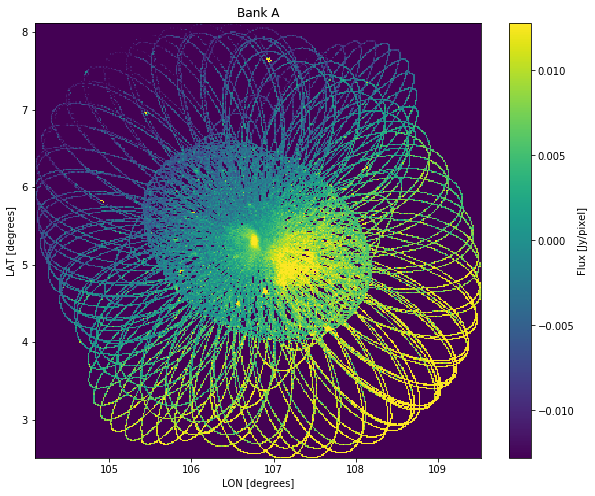

In [64]:
get_map_gal('A', '2', pixbeam=1.)

In [69]:
def calculate_sflux(bank='A', session='5', doplot=True, pixbeam=1., smth=None, removeplane=False):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/datamaps_'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units
    # beam and pixbeam are in arcminutes
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    # ras and decs are in degrees 
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= 1.
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    annulus = (radius >= 80./60.) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0
    
    if removeplane:
        rabinsc = (rabins[1:] + rabins[:-1]) / 2.
        decbinsc = (decbins[1:] + decbins[:-1]) / 2.
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        masks = ~np.isnan(Z) * (~innerregion.flatten()) * (~outerregion.flatten())
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
        
    signal -= np.nanmedian(signal[outerregion])
    if smth is None:
        smth = beam
    if smth > 0:
        signal = gaussian_filter(signal, smth/pixbeam)
        shits = gaussian_filter(hits, smth/pixbeam)
        #mask = shits == 0
    signal[mask] = np.nan
    
    if doplot:
        figure()
        pc = pcolormesh(rabins, decbins, signal)
        clim(-0.1*units, 0.1*units)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Flux [Jy/pixel]')
        title('Bank '+bank)
        savefig('figures/map'+bank+session+'gradientremoved')

    #print np.nanstd(signal[outerregion]) * sum(innerregion)
    return np.nansum(signal[innerregion])#, rabins, decbins, signal

38.191897011789521

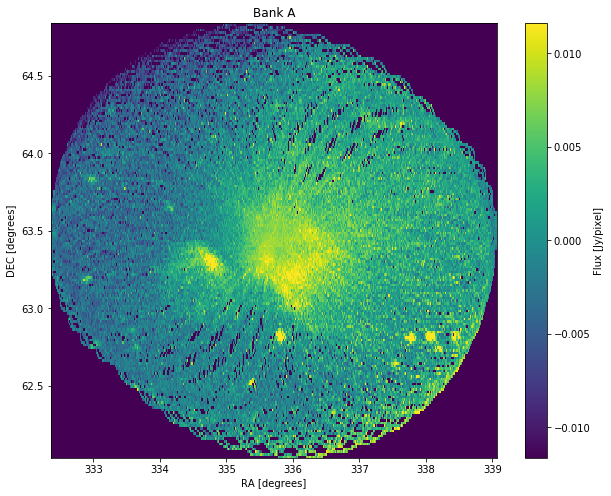

In [70]:
calculate_sflux('A', '5', pixbeam=1., smth=0, removeplane=True)

38.484590935565812

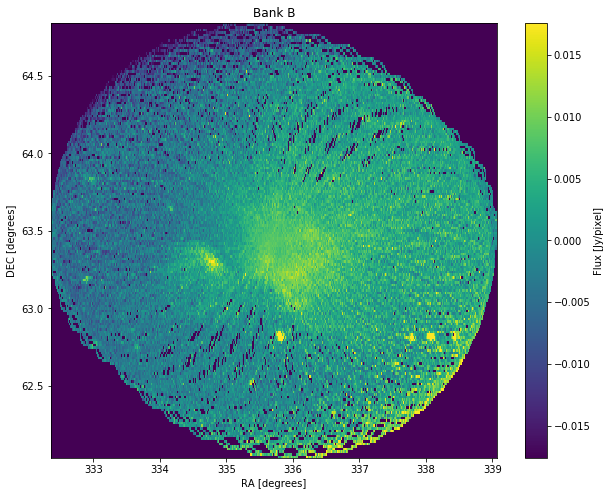

In [30]:
calculate_sflux('B', '5', pixbeam=1., smth=0, removeplane=True)

38.949395854333261

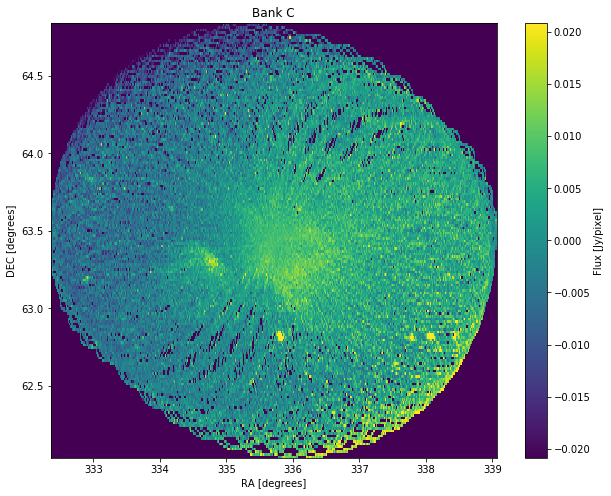

In [31]:
calculate_sflux('C', '5', pixbeam=1., smth=0, removeplane=True)

In [33]:
for bank in banks:
    print calculate_sflux(bank, '5', pixbeam=1., smth=0, removeplane=True, doplot=False)

38.1918970118
38.4845909356
38.9493958543
37.6884650283


In [34]:
for bank in banks:
    print calculate_sflux(bank, '2', pixbeam=1., smth=0, removeplane=True, doplot=False)

38.2461954323
41.1138562249
42.6585781517
49.9805469671


In [27]:
pixels = np.linspace(0.2, 10, 20)
fluxvspixel = []
for pix in pixels:
    fluxvspixel.append(calculate_sflux('A', '5', pixbeam=pix, removeplane=False, doplot=False, smth=0))

In [28]:
pixels = np.linspace(0.2, 10, 20)
fluxvspixelsmth = []
for pix in pixels:
    fluxvspixelsmth.append(calculate_sflux('A', '5', pixbeam=pix, removeplane=True, doplot=False, smth=0))

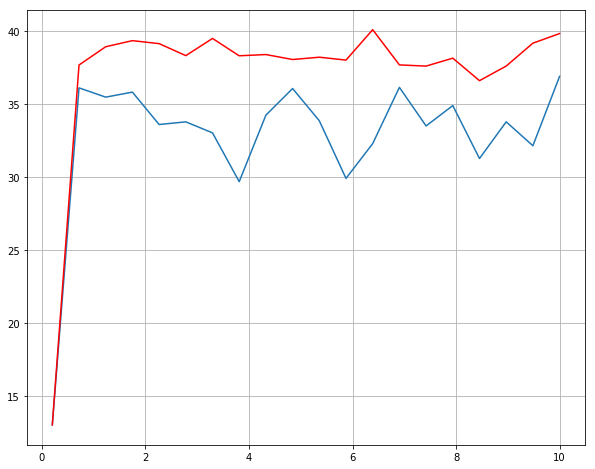

In [30]:
plot(pixels, fluxvspixel)
plot(pixels, fluxvspixelsmth, 'r')
grid()

In [31]:
pixels = np.linspace(0.2, 10, 20)
fluxvspixel = []
for pix in pixels:
    fluxvspixel.append(calculate_sflux('A', '2', pixbeam=pix, removeplane=False, doplot=False, smth=0))

In [32]:
pixels = np.linspace(0.2, 10, 20)
fluxvspixelsmth = []
for pix in pixels:
    fluxvspixelsmth.append(calculate_sflux('A', '2', pixbeam=pix, removeplane=True, doplot=False, smth=0))

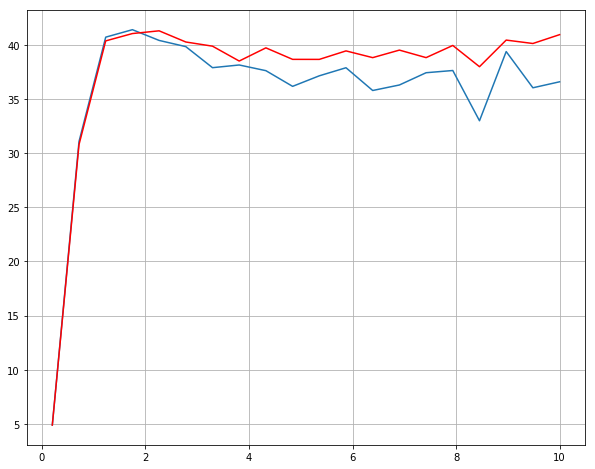

In [35]:
plot(pixels, fluxvspixel)
plot(pixels, fluxvspixelsmth, 'r')
grid()

32.332683069161334

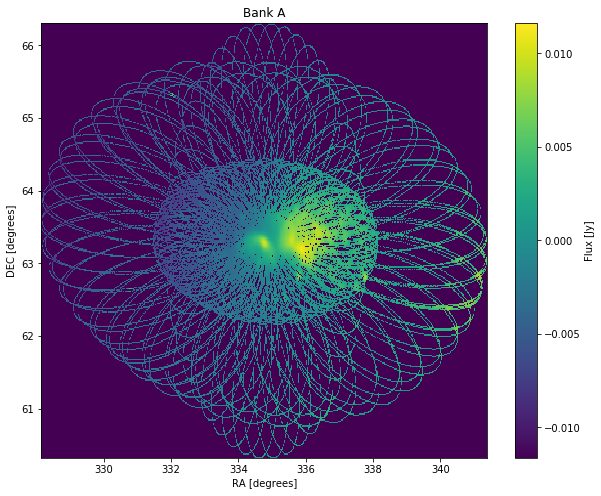

In [38]:
calculate_sflux('A', '2', pixbeam=1., smth=None, removeplane=False)

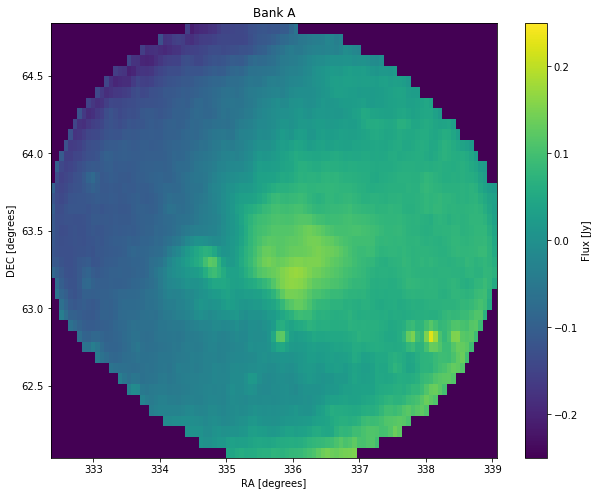

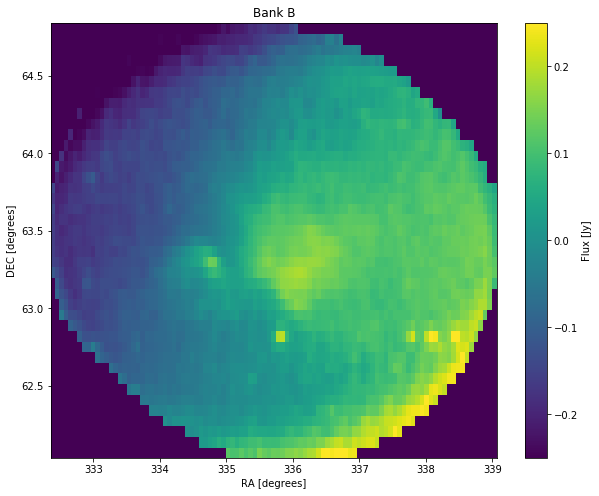

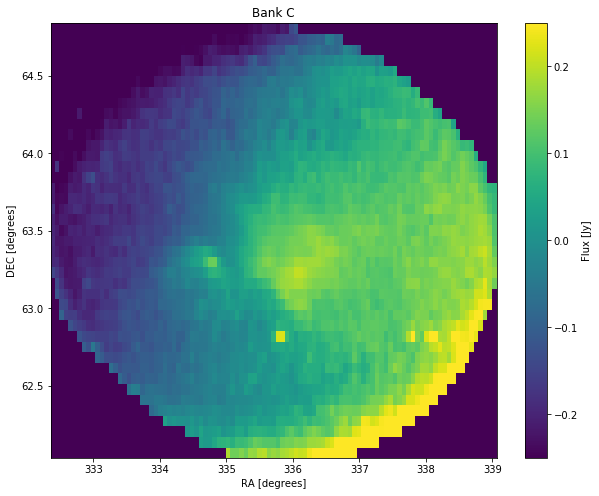

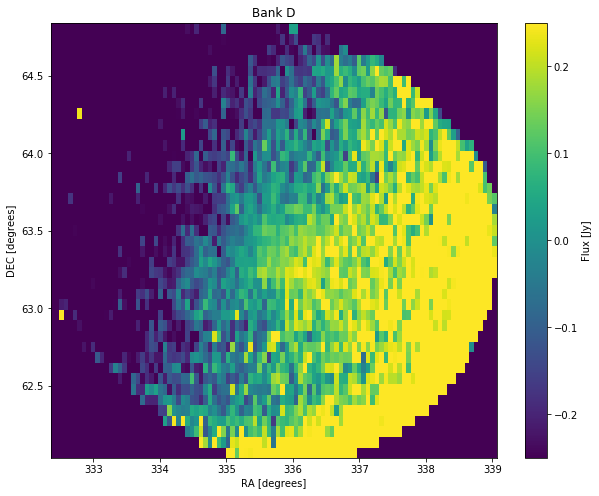

In [18]:
fluxs5 = []
for bank in banks:
    fluxs5.append(calculate_sflux(bank, '5'))

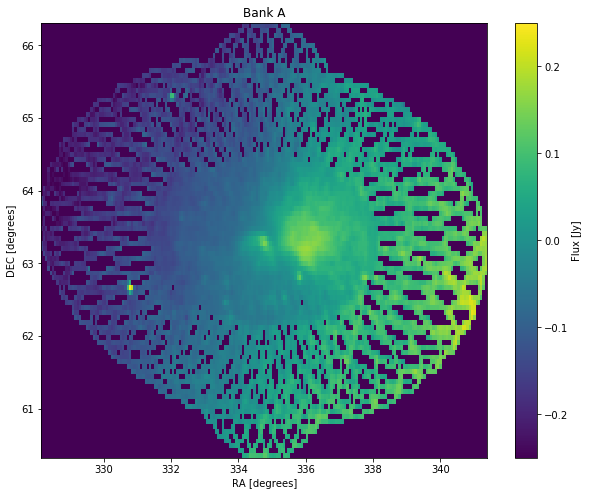

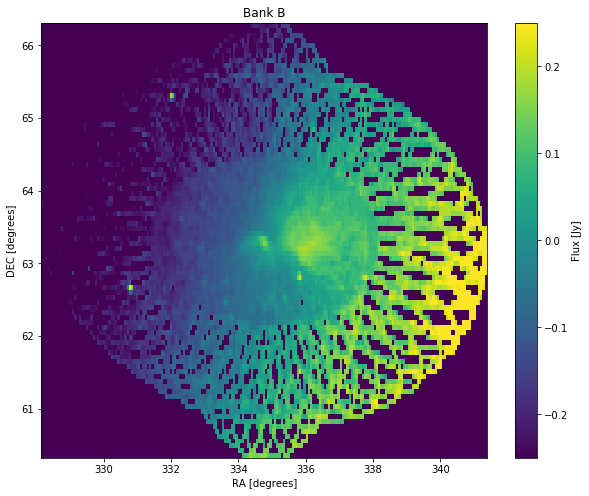

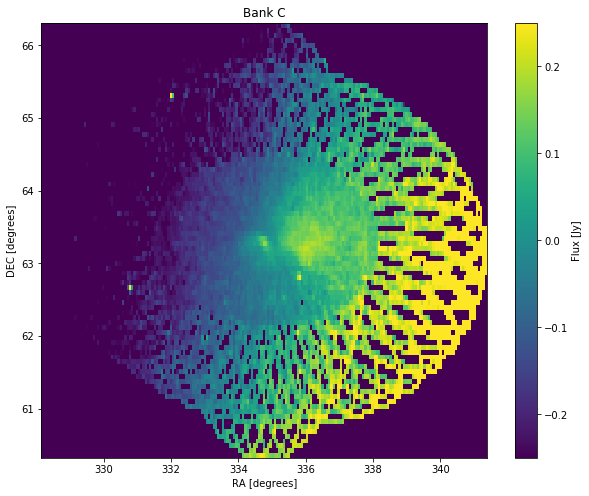

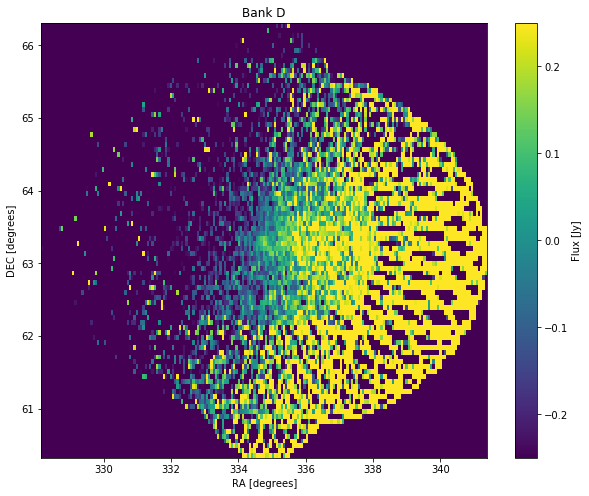

In [19]:
fluxs2 = []
for bank in banks:
    fluxs2.append(calculate_sflux(bank, '2'))

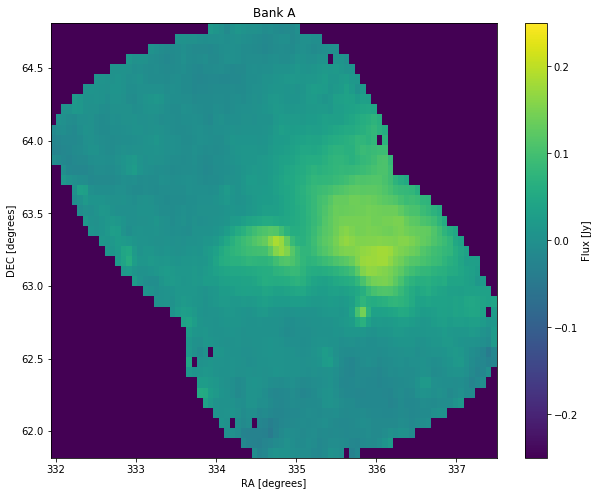

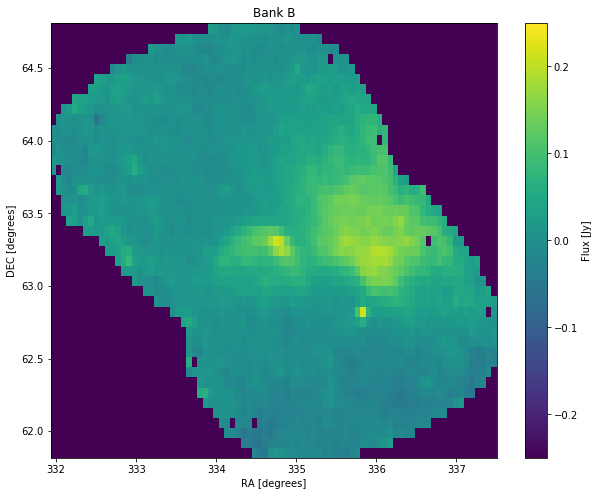

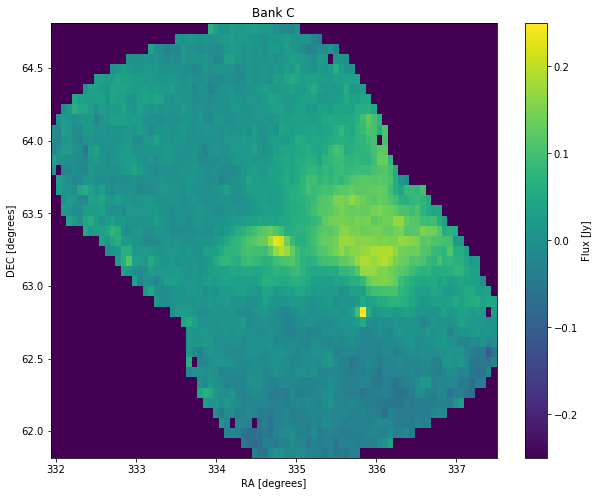

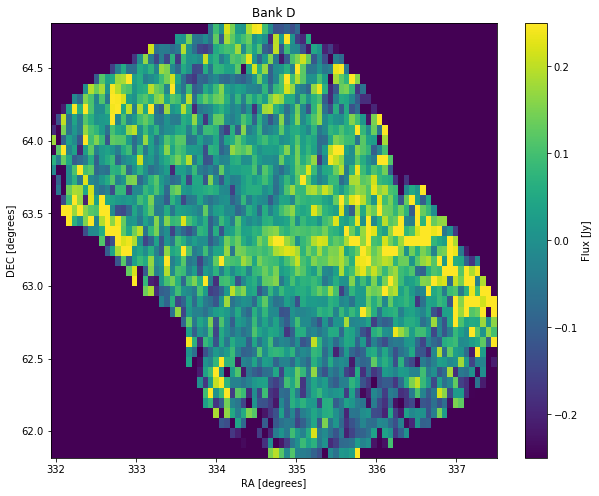

In [20]:
fluxs3 = []
for bank in banks:
    fluxs3.append(calculate_sflux(bank, '3'))

In [21]:
fluxs5 = []
for bank in banks:
    fluxs5.append(calculate_sflux(bank, '5', doplot=False))
fluxs2 = []
for bank in banks:
    fluxs2.append(calculate_sflux(bank, '2', doplot=False))
fluxs3 = []
for bank in banks:
    fluxs3.append(calculate_sflux(bank, '3', doplot=False))

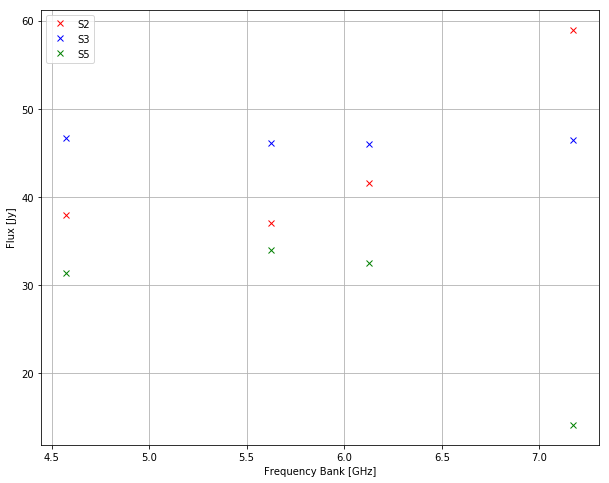

In [22]:
plot(freqs, fluxs2, 'xr', label='S2')
plot(freqs, fluxs3, 'xb', label='S3')
plot(freqs, fluxs5, 'xg', label='S5')
ylabel('Flux [Jy]')
xlabel('Frequency Bank [GHz]')
legend()
grid()

In [12]:
fluxs5 = []
for bank in banks:
    fluxs5.append(calculate_sflux(bank, '5', doplot=False))
fluxs2 = []
for bank in banks:
    fluxs2.append(calculate_sflux(bank, '2', doplot=False))
fluxs3 = []
for bank in banks:
    fluxs3.append(calculate_sflux(bank, '3', doplot=False))

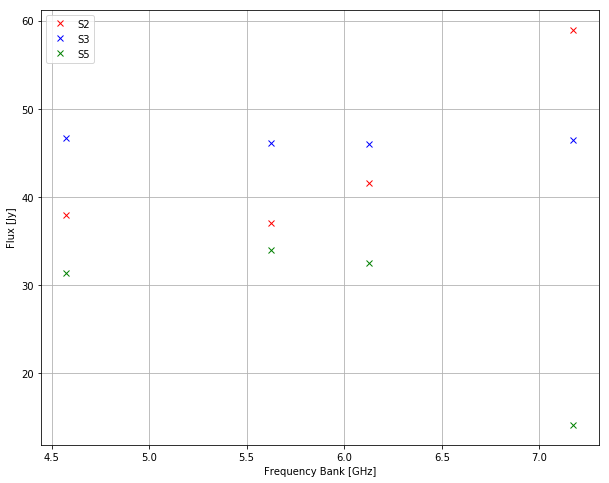

In [13]:
plot(freqs, fluxs2, 'xr', label='S2')
plot(freqs, fluxs3, 'xb', label='S3')
plot(freqs, fluxs5, 'xg', label='S5')
ylabel('Flux [Jy]')
xlabel('Frequency Bank [GHz]')
legend()
grid()